In [155]:
import numpy as np
#import pandas as pd
import math
#import csv
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [156]:
# criteria for splits
SPL_CRITERIA = ['gini', 'entropy']
# data paths
CLEAN_REAL_PATH = "data/clean_real.txt"
CLEAN_FAKE_PATH = "data/clean_fake.txt"
# class labels
REAL_LABEL = '1'
FAKE_LABEL = '0'

In [157]:
'''
this is question 3a.
''' 

def load_data():
    f = open(CLEAN_REAL_PATH, "r")
    real_headlines = f.read().splitlines() # ?
    f.close()

    f = open(CLEAN_FAKE_PATH, "r")
    fake_headlines = f.read().splitlines()
    f.close()

    count_real = len(real_headlines)
    count_fake = len(fake_headlines)
    count_total = count_real + count_fake
    all_headlines = np.asarray(real_headlines + fake_headlines) # ?
    print(all_headlines)

    vectorizer = CountVectorizer() 
    X = vectorizer.fit_transform(all_headlines)

    # Adding labels after vectorizer
    real_labels = np.full((count_real, 1), REAL_LABEL) # ?
    fake_labels = np.full((count_fake, 1), FAKE_LABEL)
    all_labels = np.append(real_labels, fake_labels)

    
    b = all_labels.reshape(1, count_total) # ? 
    y = b.T

    # 70 / 30 split into train + (test+val)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, 
        test_size=0.3, random_state=1)

    # then split 30 into 15 validation, 15 test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
        test_size=0.5, random_state=1)

    return X_train, X_val, X_test, y_train, y_val, y_test, count_total, vectorizer

In [158]:
X_train, X_val, X_test, y_train, y_val, y_test, count_total, vectorizer = load_data()

['donald trump do you remember the year since he was elected'
 'trump defends son over emails as moscow hits back'
 'donald trump strategist says media wont easily give back america' ...
 'breaking donald trump makes major clinton indictment announcement details'
 'no hate crimes have not intensified since trump election'
 'who to blame for president trump']


In [9]:
X_train.shape, X_test.shape

((2286, 5799), (490, 5799))

In [10]:
y_train.shape, y_test.shape

((2286, 1), (490, 1))

In [11]:
y_train[:10]

array([['0'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1']], dtype='<U1')

In [177]:
'''
this is question 3 b
'''

def fit_tree(params, X_train, y_train, X_val, y_val):
    """to fit the decision tree with a specific criteria and depth"""
    
    clf = DecisionTreeClassifier(
            max_depth=params["max_depth"], 
            criterion=params["criteria"],
            #splitter="random", # ?
    )
    # train 
    clf.fit(X=X_train, y=y_train) 

    # validate 
    y_pred = clf.predict(X=X_val)
    correct = sum(i == j for i, j in zip(y_pred, y_val)) # ?
    score = correct / y_val.shape[0]
    print(f"max_depth: {params['max_depth']} | criteria: {params['criteria']} | score: {score}")

    return score, clf



def select_tree_model(X_train, y_train, X_val, y_val, max_depth):
    best_score = -1
    best_tree = None
    
    # make different params 
    params = []
    for i in range(1, max_depth+1):
        for criteria in SPL_CRITERIA:
            params.append({
                "max_depth": i,
                "criteria": criteria 
            })
    
    # fit and validate on each param
    for param in params:
        score, clf = fit_tree(param, X_train, y_train, X_val, y_val)
        if (score > best_score):
            best_score = score
            best_tree = clf

    print(f"Best hyperparameters are: max_depth = {best_tree.max_depth}, criteria = {best_tree.criterion}, score = {best_score}")

    return best_tree

In [178]:
clf = select_tree_model(X_train, y_train, X_val, y_val, 20)

max_depth: 1 | criteria: gini | score: [0.58979592]
max_depth: 1 | criteria: entropy | score: [0.58979592]
max_depth: 2 | criteria: gini | score: [0.6877551]
max_depth: 2 | criteria: entropy | score: [0.63061224]
max_depth: 3 | criteria: gini | score: [0.71020408]
max_depth: 3 | criteria: entropy | score: [0.63265306]
max_depth: 4 | criteria: gini | score: [0.71428571]
max_depth: 4 | criteria: entropy | score: [0.7122449]
max_depth: 5 | criteria: gini | score: [0.7122449]
max_depth: 5 | criteria: entropy | score: [0.7122449]
max_depth: 6 | criteria: gini | score: [0.71632653]
max_depth: 6 | criteria: entropy | score: [0.71632653]
max_depth: 7 | criteria: gini | score: [0.71428571]
max_depth: 7 | criteria: entropy | score: [0.71836735]
max_depth: 8 | criteria: gini | score: [0.71836735]
max_depth: 8 | criteria: entropy | score: [0.72040816]
max_depth: 9 | criteria: gini | score: [0.73061224]
max_depth: 9 | criteria: entropy | score: [0.72857143]
max_depth: 10 | criteria: gini | score: [

In [179]:
'''
question 3 c
'''

TEST_DATA_X = 'data/data_test_X.csv'
TEST_DATA_y = 'data/data_test_y.csv'

BEST_PARAMS = {
    'max_depth' : 12,
    'criteria' : 'gini',
}

def test_model():    
    y_out = clf.predict(X_test) # ?
    
    return y_out
    

In [180]:
y_out = test_model()

In [181]:
# accuracy 
accuracy_score(y_test, y_out)

0.7714285714285715

In [184]:
# plotting the first 2 layers

def visualize(clf):
    plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
    tree.plot_tree(clf, max_depth=2, filled = True, fontsize=10, feature_names=vectorizer.get_feature_names_out())
    plt.show()
    plt.savefig('tree_depth_2', dpi=100)

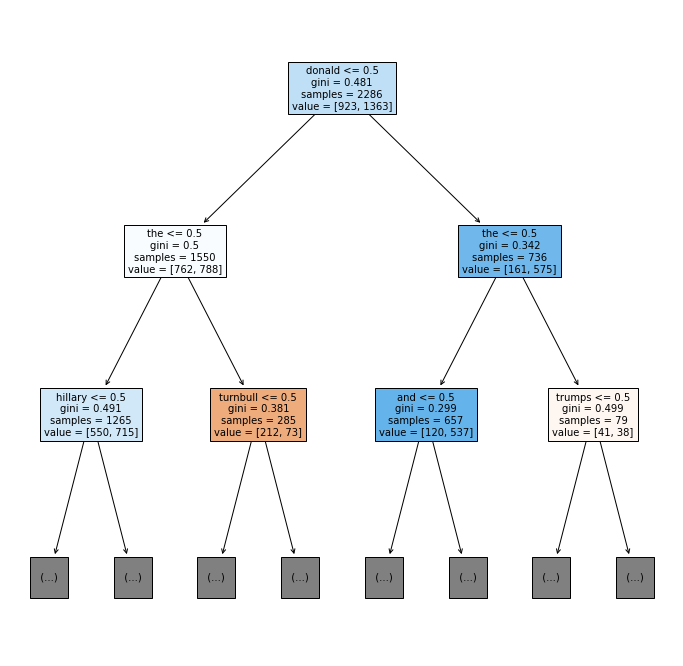

<Figure size 432x288 with 0 Axes>

In [185]:
visualize(clf)

In [151]:
"""
def findIG(x):
    """
    IG(Y, x) = Entropy before the split - Sum of entropies after the split
    """
    ndX_train = X_train.toarray()
    index = findIndexOfFeature(x)
    print(index)
    col = ndX_train.getcol(index)
    #print(col)
    #counts = np.bincount(col)
    #print(counts)
    
#print(type(X_train))
ndX = X_train.toarray()
type(ndX)
#newArray = np.concatenate([ndX,y_train])

#print(X_train[:,0].shape)
#print(X_train.getcol(1598))
#print(findIG("donald"))

def calc_entropy(column):
    """
    Calculate entropy given a pandas series, list, or numpy array.
    """
    # Compute the counts of each unique value in the column
    counts = np.bincount(column)
    # Divide by the total column length to get a probability
    probabilities = counts / len(column)
    
    # Initialize the entropy to 0
    entropy = 0
    # Loop through the probabilities, and add each one to the total entropy
    for prob in probabilities:
        if prob > 0:
            # use log from math and set base to 2
            entropy += prob * math.log(prob, 2)
    
    return -entropy

def calc_information_gain(data, split_name, target_name):
    """
    Calculate information gain given a data set, column to split on, and target
    """
    # Calculate the original entropy
    original_entropy = calc_entropy(data[target_name])
    
    #Find the unique values in the column
    values = data[split_name].unique()
    
    
    # Make two subsets of the data, based on the unique values
    left_split = data[data[split_name] == values[0]]
    right_split = data[data[split_name] == values[1]]
    
    # Loop through the splits and calculate the subset entropies
    to_subtract = 0
    for subset in [left_split, right_split]:
        prob = (subset.shape[0] / data.shape[0]) 
        to_subtract += prob * calc_entropy(subset[target_name])
    
    # Return information gain
    return original_entropy - to_subtract

import pandas as pd
#print(y_train[:,0])
#print(type(X_train))
ndX = X_train.toarray()
dfX = pd.DataFrame(data=ndX)
npY = np.array(y_train,dtype='int64')




donald = 1598
clNp = ndX[:,cl]
calc_entropy(npY[:,0])

dfX[:,1598].unique()
"""

IndentationError: unexpected indent (2727045123.py, line 4)

In [187]:
def findIndexOfFeature(feature):
    featureNames = vectorizer.get_feature_names()
    return featureNames.index(feature)

def IG(clf, featureToken):
    """
    IG(Classifier clf, int feature_id)
    ======
    Returns the information gain of a split in the feature_id given,
    the higher the information gain, the better the split.
        
    Sources:
    Tree structure: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    Mathematical formulation of Entropy used in SciKit: https://scikit-learn.org/stable/modules/tree.html
    Entropy or impuirity as per SciKit: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
    """
    # Search for feature_id
    feature_id = findIndexOfFeature(featureToken)
    
    tree_features = clf.tree_.feature
    num_features = clf.tree_.n_features
    node_samples = clf.tree_.weighted_n_node_samples
    feature_importance = np.zeros((num_features,)) # Feature importance as an array
    left_branch = clf.tree_.children_left # Index of features for left branch
    right_branch = clf.tree_.children_right # Index of features for right branch

    # Impurity is interpreted as Entropy
    entropy = clf.tree_.impurity    

    for nodeIndex,node in enumerate(clf.tree_.feature):
        if node >= 0:
            # Accumulate the feature importance over the nodes where it's used
            entropy_before_split = entropy[nodeIndex]*node_samples[nodeIndex]
            entropy_left_branch = entropy[left_branch[nodeIndex]]*node_samples[left_branch[nodeIndex]]
            entropy_right_branch = entropy[right_branch[nodeIndex]]*node_samples[right_branch[nodeIndex]]
            
            feature_importance[node] += entropy_before_split - entropy_left_branch - entropy_right_branch

    # Total number of samples at the root node
    feature_importance = feature_importance / node_samples[0]

    information_gain = -1
    
    # Adding feature_id column
    features = tree_features[tree_features>=0] # Negative feature is a leaf node
    features_list_by_id = list(zip(features,feature_importance[features]))
    for feat in features_list_by_id:
        if feat[0] == feature_id:
            information_gain = feat[1]
    
    print('The information gain (IG) of splitting the tree by ** {0} ** is {1}.'.format(featureToken, information_gain))

    return information_gain

featureIG = IG(clf, "donald")

The information gain (IG) of splitting the tree by ** donald ** is 0.03250693683486122.


In [188]:
IG(clf, "donald")

The information gain (IG) of splitting the tree by ** donald ** is 0.03250693683486122.


In [189]:
IG(clf, "hillary")

The information gain (IG) of splitting the tree by ** hillary ** is 0.019660000702676154.


0.019660000702676154

In [191]:
IG(clf, "trump")

The information gain (IG) of splitting the tree by ** trump ** is 0.003574731840877145.


0.003574731840877145

In [83]:
#feat_5143 = IG(clf, "donald")

The information gain (IG) of splitting the tree by ** donald ** is 0.03250693683486122.


In [84]:
### Comparision with native built-in function to compute the same value
IG_by_SciKit = clf.tree_.compute_feature_importances(normalize=False)
IG_by_SciKit_Non_Negative = IG_by_SciKit[np.where(IG_by_SciKit != 0)]
IG_by_SciKit_Non_Negative[::-1].sort()
print(IG_by_SciKit_Non_Negative)

[3.25069368e-02 2.53916885e-02 1.81815969e-02 1.80487109e-02
 9.90139491e-03 6.61444717e-03 5.81739522e-03 5.38487628e-03
 4.90162659e-03 4.73963982e-03 4.60051475e-03 4.47182906e-03
 4.40334529e-03 4.25923482e-03 3.63158608e-03 3.59768809e-03
 3.23319020e-03 3.22420753e-03 3.00454537e-03 2.96424834e-03
 2.79308406e-03 2.69996845e-03 2.66173880e-03 2.63675197e-03
 2.52189786e-03 2.44501098e-03 2.43606643e-03 2.33929811e-03
 2.30703819e-03 2.15239292e-03 2.14155582e-03 2.12814550e-03
 2.11197005e-03 1.56687167e-03 1.53986876e-03 1.51666923e-03
 1.50784611e-03 1.50772820e-03 1.50158535e-03 1.48473761e-03
 1.41050745e-03 1.38513254e-03 1.37488757e-03 1.27098083e-03
 1.25465798e-03 1.11988947e-03 1.08991562e-03 1.06002572e-03
 1.03944269e-03 1.01945341e-03 1.00003525e-03 9.89459651e-04
 9.81166662e-04 9.70353674e-04 9.62827099e-04 9.62041505e-04
 9.56381634e-04 9.44996967e-04 9.26354794e-04 8.76412188e-04
 8.69527849e-04 8.65060407e-04 8.64948700e-04 8.51244946e-04
 8.45836842e-04 8.455116

In [202]:
from sklearn.neighbors import KNeighborsClassifier

def test_knn_model(k_value, X_train, y_train, X_val, y_val, X_test, y_test):
    '''
    this is a helper function for question 3 e to fit knn model on a particular k value
    '''

    knn_clf = KNeighborsClassifier(n_neighbors=k_value)
    knn_clf.fit(X_train, y_train.ravel())
    
    train_score = knn_clf.score(X_train, y_train)
    val_score = knn_clf.score(X_val, y_val)
    # calculate test score only for visualisation later
    test_score = knn_clf.score(X_test, y_test)
        
    return knn_clf, val_score, train_score, test_score



"""
Function: select_knn_model(X_train, y_train, X_val, y_val, X_test, y_test)
Usage: select_knn_model(X_train, y_train, X_val, y_val, X_test, y_test)
-----
Returns the best KNN model after evauating the dataset using a range
of values between for K. It finally plots the train, validation and test errors
vs the range of the hyperparameter K.
"""
def select_knn_model(X_train, y_train, X_val, y_val, X_test, y_test):
    '''
    Question ---> 3e
    '''

    best_score = -1
    test_score_to_report = -1
    best_k = -1
    best_knn_clf = -1

    train_errors = []
    val_errors = []
    test_errors = []

    for k in range(2, 21): # all k values between 1 and 20
        knn_clf, val_score, train_score, test_score = test_knn_model(k, X_train, y_train, X_val, y_val, X_test, y_test)
        val_errors.append(1-val_score)
        train_errors.append(1-train_score)
        test_errors.append(1-test_score)
        
        # check on validation accuracy only 
        if val_score > best_score:
            best_score = val_score
            test_score_to_report = test_score
            best_k = k
            best_knn_clf = knn_clf
                

    print(f"Best val score: {best_score}, and test score: {test_score_to_report} for k = {best_k}")

    # visualisation like slide 43 in lecture slides 1

    plt.plot(train_errors, label='Train')
    plt.plot(val_errors, label = "Validation")
    # plt.plot(test_errors, label="Test")
    plt.ylabel("Error")
    plt.xlabel("K Values")
    plt.legend()
    plt.savefig('knn plot.png')
    plt.show()

Best val score: 0.6918367346938775, and test score: 0.7040816326530612 for k = 20


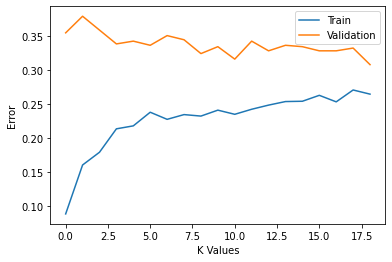

In [203]:
select_knn_model(X_train, y_train, X_val, y_val, X_test, y_test)